In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

The purpose of this project is to find out if and when an order should be immediately executed by paying (half) the Bid/Offer spread or if would be economically better to rest this order with the Bid/Offer spread for a period time to achieve possibly a better execution.

In [3]:
NOTEBOOK_ROOT = os.getcwd()
# Gbp/Usd Bid and Ask price in the market
data = pd.read_csv(os.path.join(NOTEBOOK_ROOT, "2.csv"), encoding='utf-16-le', index_col=0)
data_raw = pd.read_csv(os.path.join(NOTEBOOK_ROOT, "2.csv"), encoding='utf-16-le') # Without reindex
data.index = pd.to_datetime(data.index, format="%m/%d/%Y %H:%M:%S.%f")
data_raw.DateTime = pd.to_datetime(data_raw.DateTime, format="%m/%d/%Y %H:%M:%S.%f")
# mid market price
data['Mid']=0.5*(data['Bid']+data['Ask'])
data_raw['Mid']=0.5*(data_raw['Bid']+data_raw['Ask'])
data['Spread'] = data['Ask']-data['Bid']

In [4]:
data.head(5)

,Bid,Ask,Mid,Spread
DateTime,,,,
2018-01-07 22:02:03.832,1.35560,1.35616,1.355880,0.00056
2018-01-07 22:02:03.845,1.35560,1.35617,1.355885,0.00057
2018-01-07 22:02:03.851,1.35554,1.35617,1.355855,0.00063
2018-01-07 22:02:03.859,1.35554,1.35618,1.355860,0.00064
2018-01-07 22:02:04.114,1.35554,1.35619,1.355865,0.00065


Text(0.5,1,'Bid/Ask Price in the Market')

<Figure size 432x288 with 0 Axes>

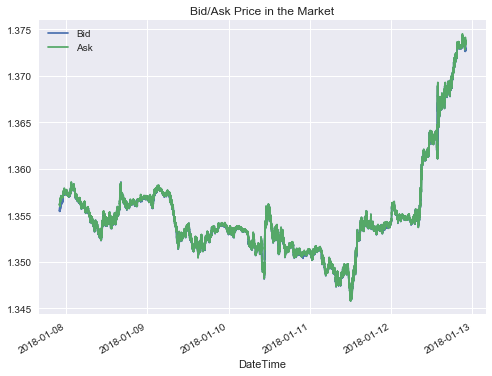

In [5]:
plt.figure()
ax = data.plot(y=['Bid', 'Ask'],figsize=(8,6))
plt.title('Bid/Ask Price in the Market')

In [6]:
# Order information
order = pd.read_csv(os.path.join(NOTEBOOK_ROOT, "Assignment#3_Orders.csv"),index_col = False)
order.dropna(axis='columns',thresh=2,inplace=True)
order.rename(columns=order.iloc[2],inplace=True)
order = order[5:]
# The first two orders don't have market price at that time, so we drop them.
order.dropna(inplace=True)
order.reset_index(drop=True,inplace=True)
order['datetime'] = pd.to_datetime(order['datetime'], format = "%m/%d/%Y %H:%M:%S.%f")

In [7]:
order.head(5)

,trade_id,buy/sell,notional,price,datetime,instrument,alpha
0,107638,-1,"310,000",1.35453,2018-01-08 07:38:48.384800,GBP/USD,SOM
1,107649,-1,"310,000",1.35371,2018-01-08 08:10:55.105500,GBP/USD,SOM
2,107654,-1,"320,000",1.35394,2018-01-08 08:19:10.191000,GBP/USD,SOM
3,107664,-1,"200,000",1.35405,2018-01-08 08:23:16.231600,GBP/USD,SOM
4,107670,-1,"490,000",1.35423,2018-01-08 08:34:40.344000,GBP/USD,SOM


In [8]:
# Find the nearest bid/ask price in the market for each order.
# Too slow to use, just for test use. :( 
# def nearest(items, pivot):
#     return min(item for item in items if item > pivot)
# O(log(N)) solution:
def nearest_fwd(items, time):
    return items.index.get_loc(time, method='pad')

# Market Taking (MT)
For each order, we will aggress the market immediately and therefore incur the (half) Bid/Offer spread. In this case, we buy at the latest Ask price and sell at the latest Bid price.


In [9]:
index_list = []
for i in range(0, len(order)):
    index = nearest_fwd(data, order.datetime[i])
    index_list.append(index)
    order.at[i,'MT_PnL']= -0.5*data.iloc[index]['Spread']

In [10]:
order.head(5)

,trade_id,buy/sell,notional,price,datetime,instrument,alpha,MT_PnL
0,107638,-1,"310,000",1.35453,2018-01-08 07:38:48.384800,GBP/USD,SOM,-0.000005
1,107649,-1,"310,000",1.35371,2018-01-08 08:10:55.105500,GBP/USD,SOM,-0.000025
2,107654,-1,"320,000",1.35394,2018-01-08 08:19:10.191000,GBP/USD,SOM,-0.000010
3,107664,-1,"200,000",1.35405,2018-01-08 08:23:16.231600,GBP/USD,SOM,-0.000015
4,107670,-1,"490,000",1.35423,2018-01-08 08:34:40.344000,GBP/USD,SOM,-0.000010


# Opportunistic Market Making (OMM)

For each order, we will rest it within the Bid/Offer spread for a given amount of time waiting for its (possible) opportunistic execution. For both case, we set:
- max Time to Execution (TTE): 10s
- max Stop Loss (SL): -0.00003

In [11]:
TTE = timedelta(seconds=10).total_seconds()
SL = -0.00003

## OMMSide
OMMSide means that we place the order on our chosen side, wait for the market to move toward us for completion. In this way, we would probably buy at Bid price and sell at Ask price.

In [12]:
def OMMSide(TTE):
    start = datetime.datetime.now()
    for i in range(0, len(order)):
        for dt in range(1,len(data)-i):
            wait_time = (data.index[index_list[i]+dt]-order.datetime[i]).total_seconds()
            order.at[i,'OMMSide_TTE'] = wait_time
            if order.at[i,'buy/sell']=='1':
                price_change = data_raw.at[index_list[i],'Mid']-data_raw.at[index_list[i]+dt,'Ask']
                loss = data_raw.at[index_list[i],'Ask']-data_raw.at[index_list[i]+dt,'Ask']
                order.at[i, 'OMMSide_PnL'] = price_change
                if wait_time < TTE and loss > SL:
                    order.at[i, 'OMMSide_TL'], order.at[i, 'OMMSide_SL'] = 0, 0
                    if data_raw.at[index_list[i]+dt,'Ask']<=data_raw.at[index_list[i],'Bid']:
                        break
                elif wait_time < TTE and loss <= SL:
                    order.at[i, 'OMMSide_TL'], order.at[i, 'OMMSide_SL'] = 0, 1
                    break
                elif wait_time >= TTE and loss > SL:
                    order.at[i, 'OMMSide_TL'], order.at[i, 'OMMSide_SL'] = 1, 0
                    break
            elif order.at[i,'buy/sell']=='-1':
                price_change = data_raw.at[index_list[i]+dt,'Bid']-data_raw.at[index_list[i],'Mid']
                loss = data_raw.at[index_list[i]+dt,'Bid']-data_raw.at[index_list[i],'Bid']
                order.at[i, 'OMMSide_PnL'] = price_change
                if wait_time < TTE and loss > SL:
                    order.at[i, 'OMMSide_TL'], order.at[i, 'OMMSide_SL'] = 0, 0
                    if data_raw.at[index_list[i]+dt,'Bid']>=data_raw.at[index_list[i],'Ask']:
                        break
                elif wait_time < TTE and loss <= SL:
                    order.at[i, 'OMMSide_TL'], order.at[i, 'OMMSide_SL'] = 0, 1
                    break
                elif wait_time >= TTE and loss > SL:
                    order.at[i, 'OMMSide_TL'], order.at[i, 'OMMSide_SL'] = 1, 0
                    break
    print(datetime.datetime.now()-start)
    return order['OMMSide_PnL'].median()


In [13]:
Side_median = OMMSide(TTE)
order.head(5)

0:00:01.517894


,trade_id,buy/sell,notional,price,datetime,instrument,alpha,MT_PnL,OMMSide_TTE,OMMSide_PnL,OMMSide_TL,OMMSide_SL
0,107638,-1,"310,000",1.35453,2018-01-08 07:38:48.384800,GBP/USD,SOM,-0.000005,2.0222,0.000015,0.0,0.0
1,107649,-1,"310,000",1.35371,2018-01-08 08:10:55.105500,GBP/USD,SOM,-0.000025,5.9765,0.000025,0.0,0.0
2,107654,-1,"320,000",1.35394,2018-01-08 08:19:10.191000,GBP/USD,SOM,-0.000010,1.9520,-0.000040,0.0,1.0
3,107664,-1,"200,000",1.35405,2018-01-08 08:23:16.231600,GBP/USD,SOM,-0.000015,13.5214,-0.000015,1.0,0.0
4,107670,-1,"490,000",1.35423,2018-01-08 08:34:40.344000,GBP/USD,SOM,-0.000010,0.5340,0.000010,0.0,0.0


## OMMMid
OMMMid means that we place the order on the mid-price, wait for the market to move toward us for completion. In this way, we would probably buy and sell at mid-price.

In [14]:
def OMMMid(TTE):
    start = datetime.datetime.now()
    for i in range(0, len(order)):
        for dt in range(1,len(data)-i):
            wait_time = (data.index[index_list[i]+dt]-order.datetime[i]).total_seconds()
            order.at[i,'OMMMid_TTE'] = wait_time
            if order.at[i,'buy/sell']=='1':
                price_change = data_raw.at[index_list[i],'Mid']-data_raw.at[index_list[i]+dt,'Ask']
                loss = data_raw.at[index_list[i],'Ask']-data_raw.at[index_list[i]+dt,'Ask']
                order.at[i, 'OMMMid_PnL'] = price_change
                if wait_time < TTE and loss > SL:
                    order.at[i, 'OMMMid_TL'], order.at[i, 'OMMMid_SL'] = 0, 0
                    if data_raw.at[index_list[i]+dt,'Ask']<=data_raw.at[index_list[i],'Mid']:
                        break
                elif wait_time < TTE and loss <= SL:
                    order.at[i, 'OMMMid_TL'], order.at[i, 'OMMMid_SL'] = 0, 1
                    break
                elif wait_time >= TTE and loss > SL:
                    order.at[i, 'OMMMid_TL'], order.at[i, 'OMMMid_SL'] = 1, 0
                    break
            elif order.at[i,'buy/sell']=='-1':
                price_change = data_raw.at[index_list[i]+dt,'Bid']-data_raw.at[index_list[i],'Mid']
                loss = data_raw.at[index_list[i]+dt,'Bid']-data_raw.at[index_list[i],'Bid']
                order.at[i, 'OMMMid_PnL'] = price_change
                if wait_time < TTE and loss > SL:
                    order.at[i, 'OMMMid_TL'], order.at[i, 'OMMMid_SL'] = 0, 0
                    if data_raw.at[index_list[i]+dt,'Bid']>=data_raw.at[index_list[i],'Mid']:
                        break
                elif wait_time < TTE and loss <= SL:
                    order.at[i, 'OMMMid_TL'], order.at[i, 'OMMMid_SL'] = 0, 1
                    break
                elif wait_time >= TTE and loss > SL:
                    order.at[i, 'OMMMid_TL'], order.at[i, 'OMMMid_SL'] = 1, 0
                    break
    print(datetime.datetime.now()-start)
    return order['OMMMid_PnL'].median()


In [15]:
Mid_median = OMMMid(TTE)
Order = order.copy(deep=True)
order.head(5)

0:00:01.082369


,trade_id,buy/sell,notional,price,datetime,instrument,alpha,MT_PnL,OMMSide_TTE,OMMSide_PnL,OMMSide_TL,OMMSide_SL,OMMMid_TTE,OMMMid_PnL,OMMMid_TL,OMMMid_SL
0,107638,-1,"310,000",1.35453,2018-01-08 07:38:48.384800,GBP/USD,SOM,-0.000005,2.0222,0.000015,0.0,0.0,2.0222,1.500000e-05,0.0,0.0
1,107649,-1,"310,000",1.35371,2018-01-08 08:10:55.105500,GBP/USD,SOM,-0.000025,5.9765,0.000025,0.0,0.0,0.6945,5.000000e-06,0.0,0.0
2,107654,-1,"320,000",1.35394,2018-01-08 08:19:10.191000,GBP/USD,SOM,-0.000010,1.9520,-0.000040,0.0,1.0,1.9520,-4.000000e-05,0.0,1.0
3,107664,-1,"200,000",1.35405,2018-01-08 08:23:16.231600,GBP/USD,SOM,-0.000015,13.5214,-0.000015,1.0,0.0,13.5214,-1.500000e-05,1.0,0.0
4,107670,-1,"490,000",1.35423,2018-01-08 08:34:40.344000,GBP/USD,SOM,-0.000010,0.5340,0.000010,0.0,0.0,0.4770,2.220446e-16,0.0,0.0


# Analysis
## PnL Performance Analysis

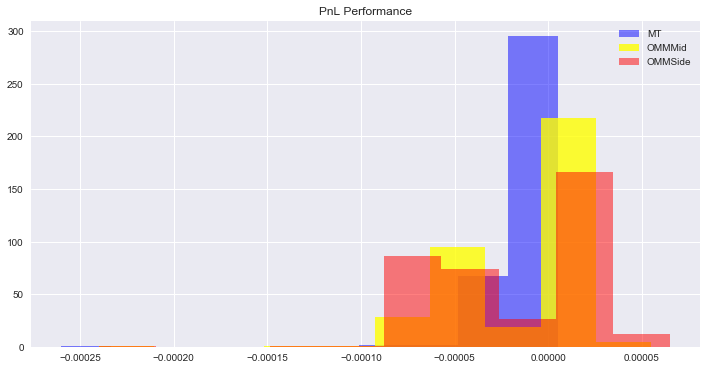

In [75]:
PnL_hist = plt.figure(figsize=(12, 6))
ax = PnL_hist.add_subplot(111)
_ = order['MT_PnL'].hist(alpha=0.5, color='blue', ax=ax, label='MT')
_ = order['OMMMid_PnL'].hist(alpha=0.8, color='yellow', ax=ax, label='OMMMid')
_ = order['OMMSide_PnL'].hist(alpha=0.5, color='red', ax=ax, label='OMMSide')
_ = plt.title('PnL Performance')
_ = ax.legend()

In [17]:
# Calculate min, mean, median and std for PnLs of three Methods.
MT_min, MT_mean, MT_median, MT_std = order['MT_PnL'].min(), order['MT_PnL'].mean(), order['MT_PnL'].median(), order['MT_PnL'].std()
OMMSide_min, OMMSide_mean, OMMSide_median, OMMSide_std = order['OMMSide_PnL'].min(), order['OMMSide_PnL'].mean(), order['OMMSide_PnL'].median(), order['OMMSide_PnL'].std()
OMMMid_min, OMMMid_mean, OMMMid_median, OMMMid_std = order['OMMMid_PnL'].min(), order['OMMMid_PnL'].mean(), order['OMMMid_PnL'].median(), order['OMMMid_PnL'].std()

pnl = {'MT':[MT_min, MT_mean, MT_median, MT_std], 'OMMSide':[OMMSide_min, OMMSide_mean, OMMSide_median, OMMSide_std], 'OMMMid':[OMMMid_min, OMMMid_mean, OMMMid_median, OMMMid_std]}
PnL = pd.DataFrame(data = pnl, index = ['PnL min (bps)', 'PnL mean (bps)', 'PnL_median', 'PnL_std'])
PnL

,MT,OMMSide,OMMMid
PnL_min,-0.000260,-0.000240,-0.000240
PnL_mean,-0.000019,-0.000017,-0.000018
PnL_median,-0.000020,-0.000015,-0.000005
PnL_std,0.000015,0.000035,0.000030


We learn from the table that
- **mean** : OMMSide > MT > OMMMid
- **median & min**: MT > OMMSide = OMMMid
- **std**: OMMSide > OMMMid > MT  


1. OMMSide has the highest PnL_mean, thanks to the **opportunistic executions**. However, the MT Method has a higher PnL_mean than that of OMMMid, illustrating that OMM Method doesn't always guarantee a result in our favor.  
2. The MT Method has a higher median & min because it's **less risky** than OMM Method.  
3. Besides, we also introduce **standard deviation (std)** to our analysis, which stands for volatility. We learn that OMMSide has the highest volatility due to its risky. OMMMid has lower volatility, but still higher than MT Method because it's still waiting for some opportunities.

## TTE Analysis

Here we use MT Method TTE as benchmark. The result below is the **exceed time** of OMM Method TTE compared to MT Method.

In [18]:
# Calculate mean and median TTE for OMM Method.
SideTTE_mean, SideTTE_median = order['OMMSide_TTE'].mean(), order['OMMSide_TTE'].median()
MidTTE_mean, MidTTE_median = order['OMMMid_TTE'].mean(), order['OMMMid_TTE'].median()

tte = {'OMMSide':[SideTTE_mean, SideTTE_median], 'OMMMid':[MidTTE_mean, MidTTE_median]}
TTE = pd.DataFrame(data = tte, index = ['TTE_mean', 'TTE_median'])
TTE

,OMMSide,OMMMid
TTE_mean,8.150843,6.924192
TTE_median,7.428000,4.779800


We learn from the table that OMMSide has longer mean & median Time To Execution than that of OMMMid. Obviously, we are willing to wait for the market to move toward us and make a profit, even though it would take longer time.

## Stop Loss & Time Limit Analysis

In [19]:
# Count the number of times when Stop Loss & Time Limit are triggered.
Side_TL, Side_SL = order['OMMSide_TL'].sum(), order['OMMSide_SL'].sum()
Mid_TL, Mid_SL = order['OMMMid_TL'].sum(), order['OMMMid_SL'].sum()

trigger = {'OMMSide':[Side_TL, Side_SL], 'OMMMid':[Mid_TL, Mid_SL]}
Trigger = pd.DataFrame(data = trigger, index = ['TimeLimit_count', 'StopLoss_count'])
Trigger

,OMMSide,OMMMid
TimeLimit_count,140.0,107.0
StopLoss_count,104.0,88.0


Both OMM Methods are more likely to be triggered by **Time Limit**. Market Bid/Ask prices are updated frequently at most time, so it's less likely to trigger the Time Limit.   
In addition, OMMSide method incurs more Time Limit and Stop Loss trigger compared to OMMMid method because the condition we set is **harder to realize**.

## Recapitulating Table 

In [20]:
Recap = pd.concat([PnL, TTE, Trigger],sort=False)
Recap

,MT,OMMSide,OMMMid
PnL_min,-0.000260,-0.000240,-0.000240
PnL_mean,-0.000019,-0.000017,-0.000018
PnL_median,-0.000020,-0.000015,-0.000005
PnL_std,0.000015,0.000035,0.000030
TTE_mean,NaN,8.150843,6.924192
TTE_median,NaN,7.428000,4.779800
TimeLimit_count,NaN,140.000000,107.000000
StopLoss_count,NaN,104.000000,88.000000


We learn from the Recapitulating Table that
- MT Method is less risky and has higher PnL_median & PnL_min whereas OMMSide has highest PnL_mean thanks to the opportunistic executions. Overall, OMM Method is more volatile than MT Method.
- OMMSide has longer mean & median Time To Execution because we are willing to wait for the market to move toward us and make a profit, even though it would take longer time.
- Both OMM Methods are more likely to be triggered by __Time Limit__. OMMSide method incurs more Time Limit and Stop Loss trigger compared to OMMMid method because the condition we set is harder to realize. 

Above all, MT Method has a stable PnL because it's less possible to be exposed to the market risk. OMM Method has larger volatility since we are willing to wait for a (possible) opportunistic execution. **The harder the condition can be realized, the more profit we can gain and the longer TTE we have to wait.** Mentioned that OMM Method doesn't always guarantee a result in our favor. Sometimes we would get a worse PnL Performance if the market continues to move away from us.


# Further Analysis
## the influence of the length of TTE

In [21]:
#TTE_list = [5,6,7,8,9,10,12,15,20,30,40,50]
TTE_list = [5,10,15,20,25,30,35,40,45,50]
OMMSide_medians, OMMMid_medians = [], []

for tte in TTE_list:
    Side_median, Mid_median = OMMSide(tte), OMMMid(tte)
    OMMSide_medians.append(Side_median)
    OMMMid_medians.append(Mid_median)

0:00:01.282788
0:00:01.150771
0:00:01.689497
0:00:01.153017
0:00:01.697446
0:00:01.218844
0:00:01.854693
0:00:01.512367
0:00:02.223351
0:00:01.590007
0:00:02.649729
0:00:01.569522
0:00:02.574853
0:00:01.833279
0:00:02.778765
0:00:01.690773
0:00:03.070967
0:00:01.847858
0:00:02.855706
0:00:01.916066


In [22]:
tte_infl = {'OMMSide':OMMSide_medians, 'OMMMid':OMMMid_medians}
TTE_INFL = pd.DataFrame(data = tte_infl, index = TTE_list)

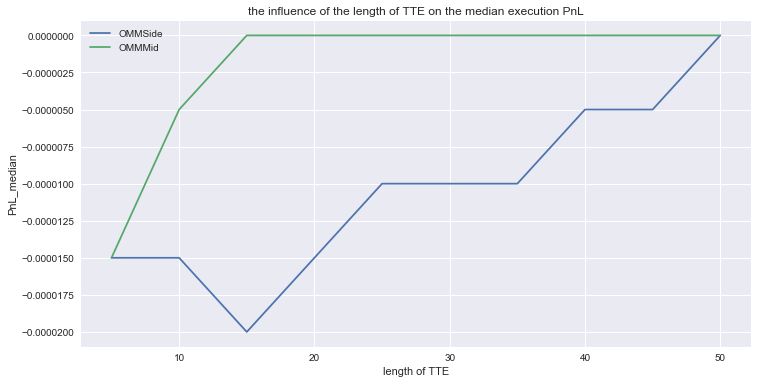

In [80]:
PnL_TTE = plt.figure(figsize=(12, 6))
ax = PnL_TTE.add_subplot(111)
_ = TTE_INFL.plot(y=['OMMSide', 'OMMMid'], use_index=True, ax=ax)
_ = ax.set_xlabel('length of TTE')
_ = ax.set_ylabel('PnL_median') 
_ = plt.title('the influence of the length of TTE on the median execution PnL')

As is shown from the figure above,  
**- Both PnL medians of OMMSide and OMMMid increase as the time to execute increases.**  
**- The PnL median of OMMMid increase much faster than OMMSide as the time to execute increases.**  
**- The PnL median of OMMSide is always smaller than the OMMMid's.**  
Intuitively, the longer we wait in the market, the more chance the market have of moving toward us.

## Alpha Analysis
Each order was labelled as either DIS or MAR or SOM. These are three different alpha generators. In this part, we analyze the difference in term of execution.

In [24]:
Order.price = Order.price.astype(float)

In [27]:
# Calculate the execution cost of each order.
# The Execution PnL is the order execute price compared to the mid price in the market.
for i in range(0, len(Order)):
    if Order.at[i,'buy/sell']=='1':
        Order.at[i, 'Execution_PnL'] = data_raw.at[index_list[i],'Mid'] - Order.at[i, 'price']
    elif Order.at[i,'buy/sell']=='-1':
        Order.at[i, 'Execution_PnL'] = Order.loc[i, 'price'] - data_raw.at[index_list[i],'Mid']

In [106]:
alpha = Order.groupby('alpha')
# Count the number of time different alphas are used in orders.
alpha_count = Order.groupby('alpha')['trade_id'].nunique().to_frame()

# Calculate the average of PnL groupby alpha.
alpha_PnL = alpha['MT_PnL','OMMSide_PnL', 'OMMMid_PnL', 'Execution_PnL'].mean()
Alpha1 = pd.concat([alpha_PnL, alpha_count],axis=1,sort=False)
display(Alpha1)

,MT_PnL,OMMSide_PnL,OMMMid_PnL,Execution_PnL,trade_id
alpha,,,,,
DIS,-0.000017,-0.000016,-0.000018,-0.001352,60
MAR,-0.000016,-0.000023,-0.000022,0.000619,59
SOM,-0.000020,-0.000016,-0.000017,-0.001868,248


We learn from the table that
- **Execution_PnL**: MAR > DIS > SOM
- **MT_PnL & OMMMid_PnL**: DIS = MAR > SOM
- **OMMSide_PnL**: DIS > MAR > SOM


1. MAR performed better in term of execution with a positive average PnL while SOM got the worst performance.
2. Both DIS and MAR had a relatively good performance on average MT_PnL & OMMMid_PnL.
3. DIS performed slightly better on average OMMSide_PnL (opportunistic execution).
4. We have more SOM orders in our data. It looks like the number of orders has a negative relationship with the average PnL. The reason might be the transaction cost during each execution.

To conclude, we believe that MAR > DIS > SOM in term of average PnL performance.

In [91]:
Alpha2 = alpha['OMMSide_TTE', 'OMMMid_TTE'].mean()
display(Alpha2)

,OMMSide_TTE,OMMMid_TTE
alpha,,
DIS,6.521913,5.219447
MAR,6.071027,5.504180
SOM,9.039734,7.674456


On average, DIS orders have the shortest time to execute(TTE) whereas SOM have the longest one. A moderate TTE may lead to a better PnL performance.

In [92]:
Alpha3 = alpha['OMMSide_TL', 'OMMMid_TL', 'OMMSide_SL', 'OMMMid_SL'].mean()
display(Alpha3)

,OMMSide_TL,OMMMid_TL,OMMSide_SL,OMMMid_SL
alpha,,,,
DIS,0.350000,0.250000,0.283333,0.266667
MAR,0.220339,0.169492,0.423729,0.355932
SOM,0.427419,0.330645,0.250000,0.205645


We learn from the table that
- **Time Limit(TL)**: SOM triggered most Time Limit while MAR rarely did so.
- **Stop Loss(SL)**: MAR triggered most Stop Loss while SOM did so less frequently.

We may draw the conclusion that Stop Loss(SL) trigger has a positive relationship with the PnL performance while Time Limit(TL) trigger has a negative one. The more time we wait, the more risk we are exposed to. An appropriate Stop Loss is critical in high-frequency trading.

# Annex: Order Summary

In [98]:
Order

,trade_id,buy/sell,notional,price,datetime,instrument,alpha,MT_PnL,OMMSide_TTE,OMMSide_PnL,OMMSide_TL,OMMSide_SL,OMMMid_TTE,OMMMid_PnL,OMMMid_TL,OMMMid_SL,Execution_PnL
0,107638,-1,"310,000",1.35453,2018-01-08 07:38:48.384800,GBP/USD,SOM,-0.000005,2.0222,1.500000e-05,0.0,0.0,2.0222,1.500000e-05,0.0,0.0,0.000305
1,107649,-1,"310,000",1.35371,2018-01-08 08:10:55.105500,GBP/USD,SOM,-0.000025,5.9765,2.500000e-05,0.0,0.0,0.6945,5.000000e-06,0.0,0.0,-0.000425
2,107654,-1,"320,000",1.35394,2018-01-08 08:19:10.191000,GBP/USD,SOM,-0.000010,1.9520,-4.000000e-05,0.0,1.0,1.9520,-4.000000e-05,0.0,1.0,0.000160
3,107664,-1,"200,000",1.35405,2018-01-08 08:23:16.231600,GBP/USD,SOM,-0.000015,13.5214,-1.500000e-05,1.0,0.0,13.5214,-1.500000e-05,1.0,0.0,0.000515
4,107670,-1,"490,000",1.35423,2018-01-08 08:34:40.344000,GBP/USD,SOM,-0.000010,0.5340,1.000000e-05,0.0,0.0,0.4770,2.220446e-16,0.0,0.0,0.000410
5,107726,1,"200,000",1.35716,2018-01-08 11:25:13.251300,GBP/USD,SOM,-0.000015,3.0887,-5.500000e-05,0.0,1.0,3.0887,-5.500000e-05,0.0,1.0,-0.002775
6,107733,1,"310,000",1.35693,2018-01-08 11:42:08.428000,GBP/USD,SOM,-0.000010,0.0990,-4.000000e-05,0.0,1.0,0.0990,-4.000000e-05,0.0,1.0,-0.002550
7,107737,1,"310,000",1.35676,2018-01-08 12:15:34.153400,GBP/USD,SOM,-0.000020,4.1616,2.000000e-05,0.0,0.0,4.1116,1.000000e-05,0.0,0.0,-0.002220
8,107738,1,"310,000",1.35677,2018-01-08 12:15:35.153500,GBP/USD,SOM,-0.000020,3.1615,2.000000e-05,0.0,0.0,3.1115,1.000000e-05,0.0,0.0,-0.002230
9,107739,1,"320,000",1.35645,2018-01-08 12:20:20.202000,GBP/USD,SOM,-0.000015,6.1550,1.500000e-05,0.0,0.0,0.5000,5.000000e-06,0.0,0.0,-0.001905


We use the parameters below for the three strategies:  
__- max Time to Execution (TTE): 10s__  
__- max Stop Loss (SL): -0.00003__

# PnL Performance Analysis

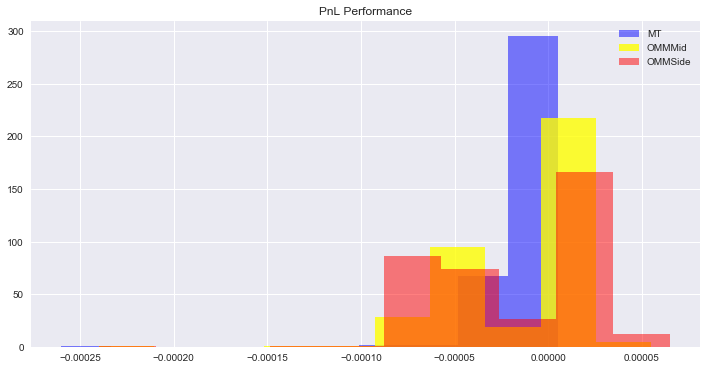

In [82]:
PnL_hist

As is shown in the histogram of above, the general summary is:   
- The PnL of the Market Taking strategy is much more concentrated than the other two strategies.  
- Markeing Taking's most PnLs is around and slightly less than 0.  
- The PnLs of the OMMMid and OMMSide strategies are much more dispersed.  
- Their PnLs are more volatile: higher possibility of higher PnL and higher possibility of lower PnL.

In [83]:
Recap

,MT,OMMSide,OMMMid
PnL_min,-0.000260,-0.000240,-0.000240
PnL_mean,-0.000019,-0.000017,-0.000018
PnL_median,-0.000020,-0.000015,-0.000005
PnL_std,0.000015,0.000035,0.000030
TTE_mean,NaN,8.150843,6.924192
TTE_median,NaN,7.428000,4.779800
TimeLimit_count,NaN,140.000000,107.000000
StopLoss_count,NaN,104.000000,88.000000


We learn from the Recapitulating Table that
- MT Method is less risky and has higher PnL median & PnL min whereas OMMSide has highest PnL_mean thanks to the opportunistic executions. Overall, OMM Method is more volatile than MT Method.
- OMMSide has longer mean & median Time To Execution because we are willing to wait for the market to move toward us and make a profit, even though it would take longer time.
- Both OMM Methods are more likely to be triggered by __Time Limit__. OMMSide method incurs more Time Limit and Stop Loss trigger compared to OMMMid method because the condition we set is harder to realize. 

In short,  
- MT Method has a __stable PnL__ because it's less possible to be exposed to the market risk.  
- OMM Method has __larger volatility__ since we are willing to wait for a (possible) opportunistic execution. 
- **The harder the condition can be realized, the more profit we can gain and the longer TTE we have to wait.**  
- OMM Method doesn't always guarantee a result in our favor. Sometimes we would get a worse PnL Performance if the market continues to move away from us.


# The influence of length of TTE

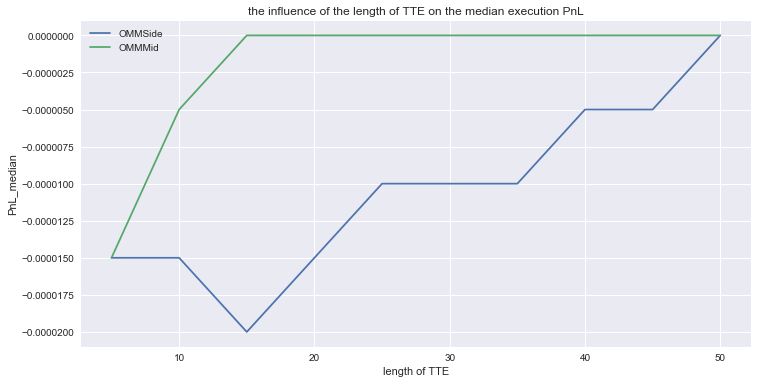

In [84]:
PnL_TTE

As is shown from the figure above,  
- Both PnL medians of OMMSide and OMMMid __increase as TTE increases__.  
- The PnL median of __OMMMid increase much faster than OMMSide__ as TTE increases.  
- The PnL median of __OMMSide is always smaller than the OMMMid's__.  

Intuitively, the longer we wait in the market, the more chance the market have of moving toward us.

# Alpha Generators Analysis

In [104]:
Alpha1.loc[:, ['MT_PnL', 'OMMSide_PnL', 'OMMMid_PnL', 'Execution_PnL']] = Alpha1.loc[:, ['MT_PnL', 'OMMSide_PnL', 'OMMMid_PnL', 'Execution_PnL']]*10000

In [107]:
Alpha1

,MT_PnL,OMMSide_PnL,OMMMid_PnL,Execution_PnL,trade_id
alpha,,,,,
DIS,-0.000017,-0.000016,-0.000018,-0.001352,60
MAR,-0.000016,-0.000023,-0.000022,0.000619,59
SOM,-0.000020,-0.000016,-0.000017,-0.001868,248


,MT_PnL,OMMSide_PnL,OMMMid_PnL,Execution_PnL,trade_id
alpha,,,,,
DIS,-0.173333,-0.158333,-0.185000,-13.524167,60
MAR,-0.164407,-0.232203,-0.223729,6.188136,59
SOM,-0.200202,-0.164315,-0.169960,-18.682339,248


We learn from the table that
- **Execution_PnL**: MAR > DIS > SOM
- **MT_PnL & OMMMid_PnL**: DIS = MAR > SOM
- **OMMSide_PnL**: DIS > MAR > SOM


1. __MAR performed better__ in term of execution with a positive average PnL while SOM got the worst performance.
2. Both DIS and MAR had a relatively good performance on average MT_PnL & OMMMid_PnL.
3. DIS performed slightly better on average OMMSide_PnL (opportunistic execution).
4. We have more SOM orders in our data. It looks like the number of orders has a negative relationship with the average PnL. The reason might be the transaction cost during each execution.

To conclude, we believe that MAR > DIS > SOM in term of average PnL performance.

In [94]:
Alpha2

,OMMSide_TTE,OMMMid_TTE
alpha,,
DIS,6.521913,5.219447
MAR,6.071027,5.504180
SOM,9.039734,7.674456


On average, DIS orders have the shortest time to execute(TTE) whereas SOM have the longest one. A moderate TTE may lead to a better PnL performance.

In [97]:
Alpha3

,OMMSide_TL,OMMMid_TL,OMMSide_SL,OMMMid_SL
alpha,,,,
DIS,0.350000,0.250000,0.283333,0.266667
MAR,0.220339,0.169492,0.423729,0.355932
SOM,0.427419,0.330645,0.250000,0.205645


We learn from the table that
- **Time Limit(TL)**: SOM triggered most Time Limit while MAR rarely did so.
- **Stop Loss(SL)**: MAR triggered most Stop Loss while SOM did so less frequently.

We may draw the conclusion that Stop Loss(SL) trigger has a positive relationship with the PnL performance while Time Limit(TL) trigger has a negative one. The more time we wait, the more risk we are exposed to. An appropriate Stop Loss is critical in high-frequency trading.